## Project Testing

### Necessary Imports

In [12]:
import os
import numpy as np
import pandas as pd
from torchinfo import summary
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch, torchvision, torchmetrics, imageio

from tqdm import tqdm
from colorama import Fore
from sklearn import preprocessing
from skimage.transform import resize
from skimage import img_as_ubyte

# Minor tensor-core speedup
torch.set_float32_matmul_precision('medium')

In [2]:
# import os
# os.environ['http_proxy'] = 'http://10.72.8.25:8080'
# os.environ['https_proxy'] = 'http://10.72.8.25:8080'

---

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

class EuroSATDataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size = 64,
                 val_split = 0.2,
                 num_workers = 4,
                 location = './data/',
                 **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.split = val_split
        self.num_workers = num_workers
        self.location = location
        self.input_shape = None
        self.output_shape = None
        self.data_train = None
        self.data_val = None

    def prepare_data(self):
        if not os.path.exists(os.path.join(self.location, '2750')):
            self._download_dataset()

    def _download_dataset(self):
        torchvision.datasets.utils.download_and_extract_archive(
            "https://madm.dfki.de/files/sentinel/EuroSAT.zip",
            download_root = self.location,
            md5 = "c8fa014336c82ac7804f0398fcb19387",
        )

    def setup(self, stage: str):
        self.prepare_data()
        dataset = torchvision.datasets.ImageFolder(root = os.path.join(self.location, '2750'))
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        self.train_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset,
                                           batch_size = self.batch_size,
                                           num_workers = self.num_workers,
                                           shuffle = True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset,
                                           batch_size = self.batch_size,
                                           num_workers = self.num_workers,
                                           shuffle = False)

In [4]:
class EuroSATDataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size = 64,
                 val_split = 0.2,
                 num_workers = 4,
                 location = './data',
                 **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.val_split = val_split
        self.num_workers = num_workers
        self.location = location
        self.input_shape = None
        self.output_shape = None
        self.data_train = None
        self.data_val = None

        self._load_data()

    def _load_data(self):
        if not os.path.exists(os.path.join(self.location, '2750')):
            self._download_dataset()
        
        images = np.zeros([27000, 64, 64, 3], dtype = "uint8")
        labels = []
        filenames = []

        i = 0
        data_dir = os.path.join(self.location, '2750')

        with tqdm(os.listdir(data_dir), bar_format = "{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)) as dir_bar:
            for item in dir_bar:
                f = os.path.join(data_dir, item)
                if os.path.isfile(f):
                    continue
                for subitem in os.listdir(f):
                    sub_f = os.path.join(f, subitem)
                    filenames.append(sub_f)

                    image = imageio.imread(sub_f)
                    if image.shape[0] != 64 or image.shape[1] != 64:
                        image = img_as_ubyte(
                            resize(
                                image, (64, 64), anti_aliasing = True)
                        )
                    images[i] = img_as_ubyte(image)
                    i += 1
                    labels.append(item)

                dir_bar.set_postfix(category = item)

        labels = np.asarray(labels)
        filenames = np.asarray(filenames)

        # sort by filenames
        images = images[filenames.argsort()]
        labels = labels[filenames.argsort()]

        # convert to integer labels
        label_encoder = preprocessing.LabelEncoder()
        label_encoder.fit(np.sort(np.unique(labels)))
        labels = label_encoder.transform(labels)
        labels = np.asarray(labels)
        # remember label encoding
        self.label_encoding = list(label_encoder.classes_)

        self.data = images
        self.targets = labels

    def _download_dataset(self):
        torchvision.datasets.utils.download_and_extract_archive(
            "https://madm.dfki.de/files/sentinel/EuroSAT.zip",
            download_root = self.location,
            md5 = "c8fa014336c82ac7804f0398fcb19387",
        )
    
    def setup(self, stage: str):
        if (stage == 'fit' or \
            stage == 'validate') and \
            not(self.data_train and self.data_val):
            x_train = self.data.transpose((0,3,1,2))
            y_train = np.array(self.targets)
            self.input_shape = x_train.shape[1:]
            self.output_shape = (len(np.unique(y_train)),)
            rng = np.random.default_rng()
            permutation = rng.permutation(x_train.shape[0])
            split_point = int(x_train.shape[0] * (1.0 - self.val_split))
            self.data_train = list(zip(torch.Tensor(x_train[permutation[:split_point]]).to(torch.float32),
                                       torch.Tensor(y_train[permutation[:split_point]]).to(torch.long)))
            self.data_val = list(zip(torch.Tensor(x_train[permutation[split_point:]]).to(torch.float32),
                                     torch.Tensor(y_train[permutation[split_point:]]).to(torch.long)))

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.data_train,
                                           batch_size = self.batch_size,
                                           num_workers = self.num_workers,
                                           shuffle = True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.data_val,
                                           batch_size = self.batch_size,
                                           num_workers = self.num_workers,
                                           shuffle = False)

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
data_module = EuroSATDataModule(batch_size = 32)

100%|██████████| 94.3M/94.3M [00:09<00:00, 9.49MB/s]


Extracting ./data/EuroSAT.zip to ./data


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/42/5jr766g57bd9bxgy6m30dz880000gn/T/ipykernel_39285/2981997001.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(sub_f)
100%|██████████| 10/10 [00:05<00:00,  1.67it/s, category=Pasture]            


In [6]:
data_module.setup('fit')

In [7]:
dl = data_module.train_dataloader()

In [8]:
batch = next(iter(dl))

In [9]:
batch

[tensor([[[[ 55.,  55.,  56.,  ...,  67.,  78.,  83.],
           [ 55.,  55.,  56.,  ...,  67.,  78.,  81.],
           [ 55.,  55.,  56.,  ...,  73.,  76.,  71.],
           ...,
           [106., 103., 100.,  ..., 103., 110.,  94.],
           [122., 116., 110.,  ...,  98., 105.,  77.],
           [147., 140., 132.,  ...,  77.,  92.,  81.]],
 
          [[ 85.,  85.,  85.,  ...,  87.,  93.,  94.],
           [ 85.,  86.,  85.,  ...,  87.,  93.,  94.],
           [ 86.,  86.,  85.,  ...,  94.,  95.,  89.],
           ...,
           [ 96.,  98.,  99.,  ..., 111., 117.,  98.],
           [ 91.,  93., 100.,  ..., 112., 118.,  87.],
           [105., 109., 116.,  ...,  94., 107.,  96.]],
 
          [[ 93.,  93.,  91.,  ...,  94., 100., 100.],
           [ 93.,  91.,  91.,  ...,  94., 100., 100.],
           [ 91.,  91.,  91.,  ...,  99.,  99.,  93.],
           ...,
           [104., 104., 105.,  ..., 122., 127., 107.],
           [ 99., 101., 108.,  ..., 121., 126.,  96.],
           

---

### Model Classes

In [13]:
class SinePositionEmbedding(pl.LightningModule):
    def __init__(self,
                 max_wavelength=10000.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.max_wavelength = torch.Tensor([max_wavelength])

    def forward(self, x):
        input_shape = x.shape
        seq_length = x.shape[-2]
        hidden_size = x.shape[-1]
        position = torch.arange(seq_length).type_as(x)
        min_freq = (1 / self.max_wavelength).type_as(x)
        timescales = torch.pow(
            min_freq,
            (2 * (torch.arange(hidden_size) // 2)).type_as(x)
            / torch.Tensor([hidden_size]).type_as(x)
        )
        angles = torch.unsqueeze(position, 1) * torch.unsqueeze(timescales, 0)
        cos_mask = (torch.arange(hidden_size) % 2).type_as(x)
        sin_mask = 1 - cos_mask
        positional_encodings = (
            torch.sin(angles) * sin_mask + torch.cos(angles) * cos_mask
        )
        return torch.broadcast_to(positional_encodings, input_shape)

In [14]:
class MLP(pl.LightningModule):
    def __init__(self,
                 latent_size = 64,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.linear1 = torch.nn.Linear(latent_size,
                                       latent_size)
        self.activation = torch.nn.GELU()
        self.linear2 = torch.nn.Linear(latent_size,
                                       latent_size)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

In [15]:
class TransformerBlock(pl.LightningModule):
    def __init__(self,
                 latent_size = 64,
                 num_heads = 4,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size)
        self.layer_norm2 = torch.nn.LayerNorm(latent_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha = torch.nn.MultiheadAttention(latent_size,
                                               num_heads,
                                               dropout=dropout,
                                               batch_first=True)
        self.mlp = MLP(latent_size,
                       dropout=dropout)
    def forward(self, x):
        y = x
        y = self.layer_norm1(y)
        y = self.mha(y,y,y)[0]
        x = y = x + y
        y = self.layer_norm2(y)
        # y = self.linear(y) # Will probably replace this with an MLP block??
        y = self.mlp(y)
        y = self.dropout(y)
        y = self.activation(y)
        return x + y

In [16]:
class LightningBoilerplate(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def predict_step(self, predict_batch, batch_idx):
        x, y_true = predict_batch
        y_pred = self.predict(x)
        return y_pred, y_true

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('train_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('val_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('test_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss

In [17]:
# Attach loss, metrics, and optimizer
class MultiClassLightningModule(LightningBoilerplate):
    def __init__(self,
                 num_classes,
                 **kwargs):
        super().__init__(**kwargs)

        self.network_metrics = torch.nn.ModuleDict({
            'acc': torchmetrics.classification.Accuracy(task='multiclass',
                                                        num_classes=num_classes)
        })

        self.network_loss = torch.nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [18]:
# Attach standardization and augmentation
class StandardizeTransformModule(MultiClassLightningModule):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
        self.standardize = torchvision.transforms.Compose([
            torchvision.transforms.Resize([256]),
            torchvision.transforms.CenterCrop([224]),
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                             std = [0.229, 0.224, 0.225]),
        ])

        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-180.0, 180.0),
                                                translate=(0.1, 0.1),
                                                scale=(0.9, 1.1),
                                                shear=(-10.0, 10.0))#,
        ])

    def forward(self, x):
        y = x
        y = self.standardize(y)
        if self.training:
            y = self.transform(y)
        return y

In [19]:
class ViTNetwork(StandardizeTransformModule):
    def __init__(self,
                 input_shape,
                 patch_shape,
                 stride_size,
                 output_size,
                 latent_size = 64,
                 num_heads = 4,
                 n_layers = 4,
                 **kwargs):
        super().__init__(num_classes=output_size,**kwargs)
        self.save_hyperparameters()

        # self.normalize = torchvision.transforms.Compose([
        #     torchvision.transforms.Lambda(lambda x: x / 255.0),
        #     torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
        #                                      std = [0.229, 0.224, 0.225]),
        # ])
        # self.transform = torchvision.transforms.Compose([
        #     torchvision.transforms.RandomAffine(degrees=(-180.0, 180.0),
        #                                         translate=(0.1, 0.1),
        #                                         scale=(0.9, 1.1),
        #                                         shear=(-10.0, 10.0))#,
        # ])
        
        self.patches = torch.nn.Conv2d(input_shape[1],
                                       latent_size,
                                       patch_shape,
                                       stride_size,
                                       bias=False)
        
        self.position_embedding = SinePositionEmbedding()
        self.transformer_blocks = torch.nn.Sequential(*[
            TransformerBlock(latent_size=latent_size,
                             num_heads=num_heads) for _ in range(n_layers)
        ])
        self.pooling = torch.nn.AdaptiveAvgPool1d(1)
        self.linear = torch.nn.Linear(latent_size,
                                      output_size)
        
    def forward(self, x):
        y = x
        y = super().forward(y)
        y = self.patches(y)
        y = y.reshape(y.shape[0:2] + (-1,)).permute(0,2,1)
        y = y + self.position_embedding(y)
        y = self.transformer_blocks(y).permute(0,2,1)
        y = self.pooling(y).squeeze()
        y = self.linear(y)
        return y    

In [20]:
data_module.output_shape[0]

10

In [21]:
batch[0].shape

torch.Size([32, 3, 64, 64])

In [22]:
vit_net = ViTNetwork(input_shape=batch[0].shape,
                     patch_shape=(16,16),
                     stride_size=(8,8),
                     output_size=data_module.output_shape[0],
                     latent_size=256,
                     n_layers=6)
summary(vit_net,input_size=batch[0].shape)

Layer (type:depth-idx)                   Output Shape              Param #
ViTNetwork                               [32, 10]                  --
├─Conv2d: 1-1                            [32, 256, 27, 27]         196,608
├─SinePositionEmbedding: 1-2             [32, 729, 256]            --
├─Sequential: 1-3                        [32, 729, 256]            --
│    └─TransformerBlock: 2-1             [32, 729, 256]            65,792
│    │    └─LayerNorm: 3-1               [32, 729, 256]            512
│    │    └─MultiheadAttention: 3-2      [32, 729, 256]            263,168
│    │    └─LayerNorm: 3-3               [32, 729, 256]            512
│    │    └─MLP: 3-4                     [32, 729, 256]            131,584
│    │    └─Dropout: 3-5                 [32, 729, 256]            --
│    │    └─GELU: 3-6                    [32, 729, 256]            --
│    └─TransformerBlock: 2-2             [32, 729, 256]            65,792
│    │    └─LayerNorm: 3-7               [32, 729, 256]     

In [23]:
logger = pl.loggers.CSVLogger("logs",
                              name="VIT-EuroSAT",
                              version="vit-eurosat")

In [24]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=5,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=True,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [27]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [29]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
trainer.validate(vit_net, data_module)

Validation: |          | 0/? [00:24<?, ?it/s]


NotImplementedError: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [67]:
trainer.fit(vit_net, data_module)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/VIT-EuroSAT/vit-eurosat/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                  | Params | Mode 
---------------------------------------------------------------------
0 | network_metrics    | ModuleDict            | 0      | train
1 | network_loss       | CrossEntropyLoss      | 0      | train
2 | patches            | Conv2d                | 196 K  | train
3 | position_embedding | SinePositionEmbedding | 0      | train
4 | transformer_blocks | Sequential            | 2.8 M  | train
5 | pooling            | AdaptiveAvgPool1d     | 0      | train
6 | linear             | Linear                | 2.6 K  | train
---------------------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.874    Total estimated model params size 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [68]:
trainer.validate(vit_net, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9448148012161255     │
│         val_loss          │    0.20276297628879547    │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.9448148012161255, 'val_loss': 0.20276297628879547}]

In [69]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,epoch,step,train_acc,train_loss,val_acc,val_loss
0,0,0,NaN,NaN,0.092407,2.523409
1,0,674,NaN,NaN,0.669259,0.982857
2,0,674,0.620880,1.069241,NaN,NaN
3,1,1349,NaN,NaN,0.812593,0.532735
4,1,1349,0.764907,0.664586,NaN,NaN
5,2,2024,NaN,NaN,0.824074,0.494373
6,2,2024,0.800185,0.568235,NaN,NaN
7,3,2699,NaN,NaN,0.816481,0.531068
8,3,2699,0.830648,0.491002,NaN,NaN
9,4,3374,NaN,NaN,0.874630,0.378683


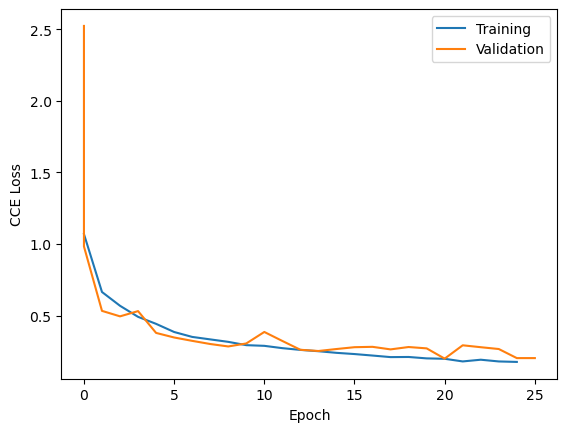

In [70]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

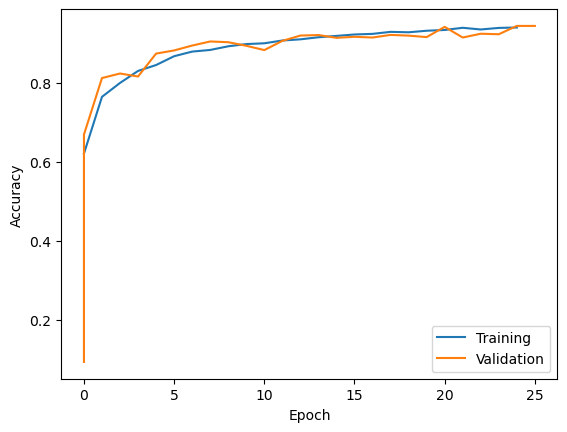

In [71]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [73]:
print("Test Accuracy:", results['val_acc'][np.logical_not(np.isnan(results['val_acc']))].iloc[-1])

Test Accuracy: 0.9448148012161256
